Test -> Was ist der Unterschied zwischen den Centroid Matching Methoden?
1. OSM zu Centroid mit ALKIS Polygonen matchen -> 2054 Matches und 72 Duplikate
2. ALKIS zu Centroid mit OSM Polygonen matchen -> 3039 Matchen und 2 Duplikate

-> Verifizierung der Dopplungen steht aus (was wurde wie gematcht, wie werden die Duplikate identifiziert?)

In [3]:
from lxml import etree
import os

In [4]:
# load gml data 
current_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
file_path = os.path.join(current_dir, 'data', 'raw', 'Bayern', '696_5346.gml')
tree = etree.parse(file_path)

# Root of xml tree
root = tree.getroot()

# explore tree
#for elem in root.iter():
#    print(f"{elem.tag}: {elem.text}")

In [5]:
ns = {
        'core': "http://www.opengis.net/citygml/2.0",
        'gml': "http://www.opengis.net/gml",
        'bldg' : 'http://www.opengis.net/citygml/building/2.0',
        'energy' : 'http://www.sig3d.org/citygml/2.0/energy/1.0',
        # Add other necessary namespaces based on the file content
    }

In [ ]:
# Suche nach dem gml:Envelope Element
from pyproj import CRS
envelope = root.find('.//gml:Envelope', namespaces=ns)
 
# Extrahiere das srsName Attribut
if envelope is not None:
    srs_name = envelope.get('srsName')
    print(f"Koordinatensystem (srsName): {srs_name}")
    srsName = "EPSG:25832"
    crs = CRS.from_string(srsName)
    print(crs)
else:
    print("gml:Envelope Element nicht gefunden.")


In [ ]:
import pandas as pd
import os
import lxml.etree as ET
import re

# Define the namespaces used in the CityGML file
ns = {
        'core': "http://www.opengis.net/citygml/2.0",
        'gml': "http://www.opengis.net/gml",
        'bldg' : 'http://www.opengis.net/citygml/building/2.0',
        'energy' : 'http://www.sig3d.org/citygml/2.0/energy/1.0',
        # Add other necessary namespaces based on the file content
    }

# Find all buildings and get the data
#for building in root.findall('.//{*}Building'):
    # Get all IDs and yoc
#    building_id = building.get('{http://www.opengis.net/gml}id')


address_df = {
    "bldg_id": [],
    "addr:city": [],
    "addr:street": [],
    "addr:housenumber": [],
}
pattern = r'^(.*\S)\s(\d+\w*)$'

for building in root.findall('.//{*}Building'):
    # Get all IDs and yoc
    building_id = building.get('{http://www.opengis.net/gml}id')
    address_node = building.find('.//{*}address')
    if address_node:
        street = address_node.find('.//{*}ThoroughfareName', ns).text
        inverted_street = street[::-1]
        street_number = inverted_street.split(" ")[0][::-1]
        street_name = inverted_street.split(" ")[1][::-1]
        city = address_node.find('.//{*}LocalityName', ns).text
        address_df["addr:city"].append(city)
        address_df["addr:street"].append(street_name)
        address_df["addr:housenumber"].append(street_number)
        #address_df["addr:street"].append(street.split(" ")[0])
    else:
        address_df["addr:city"].append(None)
        address_df["addr:street"].append(None)
        address_df["addr:housenumber"].append(None)
    address_df["bldg_id"].append(building_id)
#print(address_df)
df = pd.DataFrame(data = address_df, columns = address_df.keys()) 

In [ ]:
df.head()

In [ ]:
# Map GML ID to CEA ID 
from lxml import etree
import shapely.geometry as geom
import matplotlib.pyplot as plt
import geopandas as gpd

ns = {
    'gml': 'http://www.opengis.net/gml',
    'bldg': 'http://www.opengis.net/citygml/building/2.0',
     'bldg' :"http://www.opengis.net/citygml/building/1.0"
}
# Code taken from https://github.com/TUB-DVG/TECDEM/blob/main/experiments/92a_ModelUpdatedGML.ipynb 

# Extract building geometries along with their IDs

def extract_ground_surface_polygons_with_ids(gml_root):
    buildings = []

    # Iterate over each building
    for bldg in gml_root.findall('.//{*}Building', ns):
        bldg_id = bldg.get('{http://www.opengis.net/gml}id')
        #print(bldg)

        # Find all GroundSurface elements within the boundedBy elements
        for ground_surface in bldg.findall('.//{*}GroundSurface', ns):
            pos_list_elements = ground_surface.findall('.//gml:posList', ns)
            if pos_list_elements is not None:
                for geom_elem in pos_list_elements:
                    pos_list = geom_elem.text.split()
                    if len(pos_list) % 3 != 0:
                        print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                        continue
                    try:
                        # Convert coordinates to a 2D polygon (ignoring z-values)
                        exterior_coords = []
                        interior_coords = []
                        
                        # Find exterior coordinates
                        exterior = ground_surface.find('.//gml:exterior//gml:posList', ns)
                        if exterior is not None:
                            exterior_pos_list = exterior.text.split()
                            exterior_coords = [(float(exterior_pos_list[i]), float(exterior_pos_list[i + 1])) for i in range(0, len(exterior_pos_list), 3)]
                        
                        # Find interior coordinates
                        interiors = ground_surface.findall('.//gml:interior//gml:posList', ns)
                        for interior in interiors:
                            interior_pos_list = interior.text.split()
                            interior_coords.append([(float(interior_pos_list[i]), float(interior_pos_list[i + 1])) for i in range(0, len(interior_pos_list), 3)])
                        
                        # Create polygon with exterior and interior (holes)
                        polygon = geom.Polygon(exterior_coords, interior_coords)
                        buildings.append({'geometry': polygon, 'gml_id': bldg_id})
                    except Exception as e:
                        print(f"Error creating polygon for building {bldg_id}: {e}")
            else:
                # Alternatively, check for 'Polygon' elements under GroundSurface
                for poly in ground_surface.findall('.//gml:Polygon', ns):
                    exterior_coords = []
                    interior_coords = []
                    
                    # Find exterior coordinates
                    exterior = poly.find('.//gml:exterior//gml:posList', ns)
                    if exterior is not None:
                        exterior_pos_list = exterior.text.split()
                        if len(exterior_pos_list) % 3 != 0:
                            print(f"Warning: exterior posList does not contain triplets of coordinates: {exterior_pos_list}")
                            continue
                        exterior_coords = [(float(exterior_pos_list[i]), float(exterior_pos_list[i + 1])) for i in range(0, len(exterior_pos_list), 3)]
                    
                    # Find interior coordinates
                    interiors = poly.findall('.//gml:interior//gml:posList', ns)
                    for interior in interiors:
                        interior_pos_list = interior.text.split()
                        if len(interior_pos_list) % 3 != 0:
                            print(f"Warning: interior posList does not contain triplets of coordinates: {interior_pos_list}")
                            continue
                        interior_coords.append([(float(interior_pos_list[i]), float(interior_pos_list[i + 1])) for i in range(0, len(interior_pos_list), 3)])
                    
                    try:
                        # Create polygon with exterior and interior (holes)
                        polygon = geom.Polygon(exterior_coords, interior_coords)
                        buildings.append({'geometry': polygon, 'gml_id': bldg_id})
                    except Exception as e:
                        print(f"Error creating polygon for building {bldg_id}: {e}")

    return buildings



# Now, update the code to use the modified function
list_buildings = []
# Use the modified function that extracts only ground surfaces
print(root)
buildings = extract_ground_surface_polygons_with_ids(root)
list_buildings.extend(buildings)  # Use extend to flatten the list



In [ ]:

import osmnx as ox
import geopandas as gpd

place_name = "Garching b. München"
area = ox.geocode_to_gdf(place_name)

tags = {'building': True}   


# Comment this line out, to run the full script

buildings_osm = ox.features_from_place(place_name, tags)
buildings_osm.head()


In [ ]:
# Inspection of possible values for multi index data
unique_level1 = buildings_osm.index.get_level_values('element').unique()
unique_level1

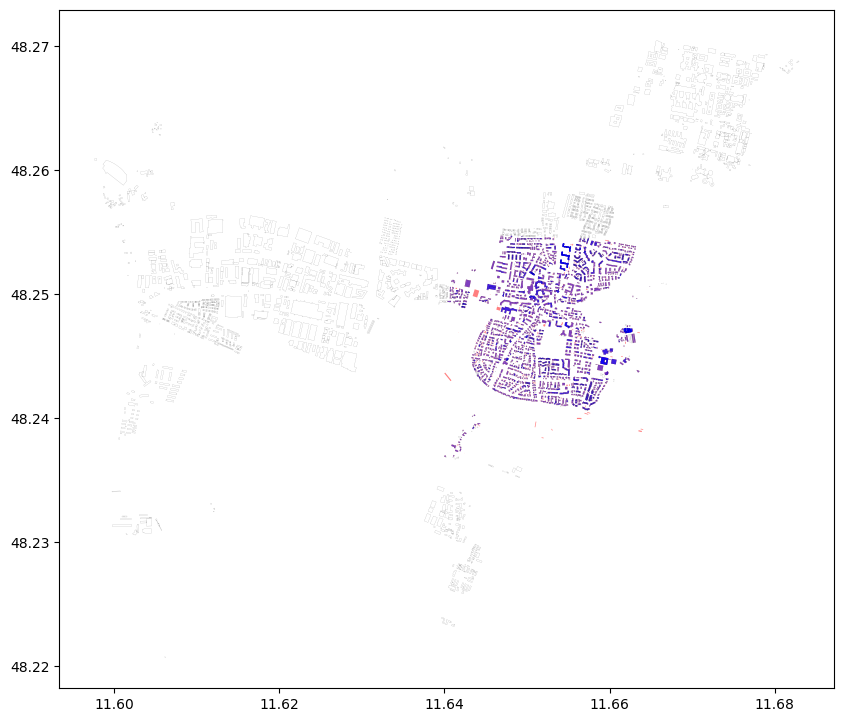

In [22]:
# Check if we have extracted any buildings
if not list_buildings:
    print("No buildings were extracted from the GML files.")
else:
    # Convert to GeoDataFrame
    
    buildings_gdf = gpd.GeoDataFrame(list_buildings, crs='EPSG:25832')
    buildings_gdf = buildings_gdf.to_crs('EPSG:4326')
    # Select columns using a list instead of a tuple
    columns_to_keep = ['addr:street', 'addr:housenumber','addr:city', 'geometry', ]
    blocks_gdf = buildings_osm[columns_to_keep]
    # Check if buildings are within blocks
    buildings_gdf = buildings_gdf.reset_index(drop=True)
    buildings_osm = buildings_osm.reset_index(drop=True)
    within_blocks = gpd.sjoin(buildings_gdf, blocks_gdf, how='inner', predicate='intersects')


    # Optional: Plotting the results for visual inspection
    fig, ax = plt.subplots(figsize=(10, 10))
    blocks_gdf.boundary.plot(ax=ax, linewidth=0.05, edgecolor='black')
    buildings_gdf.plot(ax=ax, color='red', alpha=0.5)
    within_blocks.plot(ax=ax, color='blue', alpha=0.5)
    # Comment this out, to run the script.
    plt.show()

In [ ]:
within_blocks.head()

<bldg:address>
<Address><xalAddress><xAL:AddressDetails>
 <xAL:Country>
  <xAL:CountryName>Germany</xAL:CountryName>
  <xAL:Locality Type="Town">
   <xAL:LocalityName>Garching b.München</xAL:LocalityName>
   <xAL:Thoroughfare Type="Street">
    <xAL:ThoroughfareName>Watzmannring 50</xAL:ThoroughfareName>
   </xAL:Thoroughfare>
  </xAL:Locality>
 </xAL:Country>
</xAL:AddressDetails></xalAddress>
</Address>
</bldg:address>


In [14]:
address_df = { 'bldg_id' : [], 'addr:city' : [],
    'addr:housenumber' : [],
    'addr:street' : [],
    'addr:postcode' : [], 

 }

In [ ]:
namespaces = {
    'xAL': 'urn:oasis:names:tc:ciq:xal:3',
    'bldg': 'http://www.example.com/building'
}
for building in root.findall('.//{*}Building'):
    # Get all IDs and yoc
    building_id = building.get('{http://www.opengis.net/gml}id')
    address_node = building.find('.//{*}address')
    if address_node:
        
        street = address_node.find('.//{*}ThoroughfareName', namespaces).text
        print(street)
        city = address_node.find('.//{*}LocalityName', namespaces).text
        address_df["addr:city"].append(city)
        address_df["addr:street"].append(street.split(" ")[0])
        address_df["addr:street"].append(street.split(" ")[1])
    address_df["bldg_id"].append(building_id)
    print(address_df)

In [ ]:
import pandas as pd
import os
from lxml import etree
import re

# Find all buildings and get the data
address_df = {
    "bldg_id": [],
    "addr:city": [],
    "addr:street": [], 
    "addr:housenumber": [],
}

pattern = r'^(.*\S)\s(\d+\w*)$'

for building in root.findall('.//{*}Building'):
    # Get all IDs and yoc
    building_id = building.get('{http://www.opengis.net/gml}id')
    address_node = building.find('.//{*}address')
    
    if address_node:
        street = address_node.find('.//{*}ThoroughfareName', namespaces).text
        inverted_street = street[::-1]
        street_number = inverted_street.split(" ")[0][::-1]
        street_name = inverted_street.split(" ")[1][::-1]
        city = address_node.find('.//{*}LocalityName', namespaces).text
        
        address_df["addr:city"].append(city)
        address_df["addr:street"].append(street_name)
        address_df["addr:housenumber"].append(street_number)
    else:
        address_df["addr:city"].append(None)
        address_df["addr:street"].append(None)
        address_df["addr:housenumber"].append(None)
        
    address_df["bldg_id"].append(building_id)

df = pd.DataFrame(data=address_df, columns=address_df.keys())

In [ ]:
df.head()

In GML: Garching bei München, in OSM: Garching b. München 

In [18]:
df["addr:city"]= df["addr:city"].replace({"Garching b.München" : "Garching bei München"})

In [19]:
merged_df = pd.merge(within_blocks, df, how='inner', on=['addr:street','addr:housenumber', 'addr:city'])

In [ ]:
merged_df.head()

In [ ]:
len(merged_df)